In [1]:
# import packages
import pandas as pd
import numpy as np

import xgboost as xgb

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings("ignore")

In [2]:
# load dataset and check for errors
input_df = pd.read_csv('../data/output/input_df.csv')

# remove shootouts
input_df = input_df[input_df.result != 'shootout']

------------------------------------------------------
              precision    recall  f1-score   support

           0       0.57      0.56      0.57      1405
           1       0.58      0.59      0.59      1447

    accuracy                           0.58      2852
   macro avg       0.58      0.58      0.58      2852
weighted avg       0.58      0.58      0.58      2852

Accuracy 0.5788920056100981
------------------------------------------------------


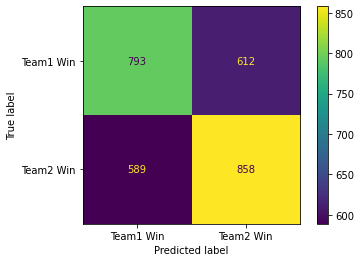

In [24]:
# set data and labels as X and y
X = input_df.drop(['teams', 'result', 'gameDate'], axis=1)
y = input_df['result']

# encode labels
label_encoder = LabelEncoder()
label_encoded_y = label_encoder.fit_transform(y)

# scale data
scaler = StandardScaler()
scaler.fit_transform(X)

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, label_encoded_y, test_size=0.2)
#X_train = X[:-948]
#X_test = X[-948:]
#y_train = y[:-948]
#y_test = y[-948:]

# construct base of XGBoost model
model = xgb.XGBClassifier(
    n_jobs=-1,
    tree_method='gpu_hist',
    objective='binary:logistic',
    eval_metric='logloss',
    use_label_encoder=False,
    
    colsample_bytree=.73,
    learning_rate=.102,
    max_depth=2,
    reg_lambda=.0775,
    subsample=.975
).fit(
    X_train, y_train,
    verbose=False,
    early_stopping_rounds=10, 
    eval_set=[(X_test, y_test)],
)

# run tests
prediction = model.predict(X_test) 

# display results
plot_confusion_matrix(model, X_test, y_test, values_format='d', display_labels=['Team1 Win', 'Team2 Win'])
print('------------------------------------------------------')
print(classification_report(y_test, prediction))

print('Accuracy', accuracy_score(y_test, prediction))
print('------------------------------------------------------')

In [4]:
#param_grid = {
#    'reg_lambda': [.7, .71, .72, .73, .74, .75, .76, .77, .78, .79, .8, .81, .82, .83, .84, .85, .86, .87, .88, .89, .9],
#
#}
#
#grid = GridSearchCV(model, param_grid, cv=5, verbose=True, n_jobs=8).fit(X_train, y_train)
#
#grid.best_params_
#
#    max_depth=5,
#    gamma=0,
#    learning_rate=.07,
#    scale_pos_weight=.925,
#    reg_lambda=4.711075,
#    subsample=.9,
#    colsample_bytree=.9,


## 